# Node2vec for network analysis

One of the hottest topic of research in deep learning is graph neural networks. The last few years saw the number of publications and libraries to analyse data have grown consistently. One of the first models to show a
considerable improvement on the tasks of node classification and link prediction is *Node2vec*. The paper by researchers at Stanford addressed one of the complexities of working with graph data; the irregularity of the data structured. While images can be represented as are grids of pixels and text can be represented as sequences of symbols, it is not as simple when it comes to graphs. Graphs do not have fixed node ordering or reference point, there is also a wide variation in the structure of the graphs e.g. one node can be connected to 100 nodes while another one may only have one connection. The authors also point to the limitations of more traditional techniques such as dimensionality reduction since they scale poorly to large networks and the resulting representations perform poorly in downstram tasks. See this really great explanation by [Jure Leskovec](http://web.stanford.edu/class/cs224w/slides/07-noderepr.pdf) one of the authors of node2vec. 

The idea behind node2vec is to generate embeddings of the nodes for using in downstream tasks. The authors avoid some of the difficulties in processing network data by creating random walks the nodes in the graph and using the information about the sequence of nodes traversed as the input data for the embedding algorithm, in this case the *skipgram* model of *word2vec*. Besides the idea of using embeddings to represent the data the model introduces *biased random walks*. The biased random walks and its parameters *p* and *q* allow the random walk to implement different exploration strategies. The return parameter *p* controls the likelihood of inmediately traveling back to a node recently traversed, and as such it can favor a breadth first search (BFS) where we explore local neighborhoods and find embeddings that better capture structural equivalence. The in-out parameter *q* controls the likelihood of walking away from the previous parameter and as such can favor a depth first search (DFS) which in turn produces embeddings that better capture homophily. To put it simply the authors generate random walks for each node to serve as sentences, and then use those sentences as a input for a shallow embedding model. 

The dataset that I will use to test the model is the bike trip data from [Capitol Bike Share](). The data comprises several million trips made between 2010 and 2020. I processed every trip as an adjacency list where the weights correspond to the number of trips made between each pair of nodes. The file to create the data can be found [here](https://github.com/jlealtru/website_tutorials/blob/main/notebooks/%20processing_capital_bikeshare_data.ipynb). To implement the node2vec algorithm I am using the really interesting library [stellargraph](https://github.com/stellargraph/stellargraph). This library contains many graph neural networks models as well as some datasets. I will be using the node2vec implementation that uses gensim as the engine to produce the embeddings with the skip gram algorithm.

As mentioned in the node2vec paper the authors evaluated the performance of the model on several node prediction and link prediction tasks,etc. For this task the nodes in the data do not have a label to evaluate the performance of the model in a downstream task. So I will limit my analysis to generate embeddings and clustering.

In [1]:
import pandas as pd
import networkx as nx
from gensim.models import Word2Vec
import stellargraph as sg
from stellargraph.data import BiasedRandomWalk
import os
import zipfile
import numpy as np
import matplotlib as plt
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import pairwise_distances
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import igraph as ig
%matplotlib inline

The stellargraph data can import an edge list from a dataframe as long as the columns are specified in the right format with the edge pairs named 'source' and 'target' and any additional attribute for the edges after. In this case I saved the data in the appropiate format so importing it into stellargraph should be trivial. I simply load the csv file as a dataframe and initialize a directed graph. 

In [2]:
# read csv data
graph_data = pd.read_csv('../data/capital_bikes/graph_data_full.csv')

In [3]:
# instantiate a directed graph with our edge list
graph_bikes = sg.StellarDiGraph(edges=graph_data)

In [4]:
# check that the attributes are correctly loaded
graph_bikes.info()

'StellarDiGraph: Directed multigraph\n Nodes: 708, Edges: 150527\n\n Node types:\n  default: [708]\n    Features: none\n    Edge types: default-default->default\n\n Edge types:\n    default-default->default: [150527]\n        Weights: range=[1, 42863], mean=175.382, std=688.561\n        Features: none'

The resulting graph has 708 different nodes (some of this stations are no longer active but I decided to include them anyways) and 150 thousand plus edges. For this graph the weights represent the number of trips between each station so we are in the presence of a directed weighted graph. Node2vec can manage both directed and undirected graphs so there is no need to conduct any additional modifications.

The next step in the analysis, and the critical part of it, is to define a list of random walks so we can use this list of *sentences* as the input for the word2vec algorithm. As mentioned in the introduction the main decision we can make revolves around how much do we want to favor the creation of embbeddings that capture homophily (communities) versus embeddings that capture the structural roles that the nodes play in the graph. I am interested in identifying bike stations that serve as hubs, meaning stations that serve links to other modes of transportation. Thus, I decided to encourage exploration of nodes in a breadh first fashion to capture structural similarities. I use the parameters defined in the paper such as length of the random walk set to 80, number of random walks per root node to 10, a return value of 0.5 to foster local exploration and an out parameter q with a value of 1. 

For the word2vec model I use 128 dimensions for the resulting embedding, training for 20 epochs and using the default parameters of the gensim implementation. It is worth mentioning that stellargraph can also generate word2vec embeddings using keras as the back end.

In [5]:
rw = BiasedRandomWalk(graph_bikes, p = 0.25, q = .9, n = 10, length = 80, 
                      seed=42, weighted = True)

In [6]:
walks = rw.run(nodes=list(graph_bikes.nodes())
               # root nodes
              )
print("Number of random walks: {}".format(len(walks)))

Number of random walks: 7080


In [7]:
# we pass the random walks to a list
str_walks = [[str(n) for n in walk] for walk in walks]

After the random walks have been generated we parse them into lists of lists. This is an easy way to feed the data to word2vec to generate the embeddings. Since we have 708 nodes and we conducted 10 random walks per node we will have 7,080 walks to feed into the model; these walks are anologous to sentences in the word2vec world. 

In [8]:
# check a few examples
str_walks[0:2]

[['10th & E St NW',
  '8th & D St NW',
  '24th & N St NW',
  'Massachusetts Ave & Dupont Circle NW',
  'Wisconsin Ave & O St NW',
  '25th St & Pennsylvania Ave NW',
  '10th St & Constitution Ave NW',
  '14th & D St NW / Ronald Reagan Building',
  "L'Enfant Plaza / 7th & C St SW",
  'Ohio Dr & West Basin Dr SW / MLK & FDR Memorials',
  'Georgetown Harbor / 30th St NW',
  "Independence Ave & L'Enfant Plaza SW/DOE",
  'USDA / 12th & Independence Ave SW',
  '3000 Connecticut Ave NW / National Zoo',
  'Calvert & Biltmore St NW',
  'Adams Mill & Columbia Rd NW',
  'Lamont & Mt Pleasant NW',
  'Tenleytown / Wisconsin Ave & Albemarle St NW',
  'Wisconsin Ave & Newark St NW',
  'Tenleytown / Wisconsin Ave & Albemarle St NW',
  'Henry Bacon Dr & Lincoln Memorial Circle NW',
  '17th & G St NW',
  '14th & Harvard St NW',
  'Calvert & Biltmore St NW',
  '14th & Harvard St NW',
  'Calvert & Biltmore St NW',
  '24th & N St NW',
  '10th & U St NW',
  '15th & P St NW',
  'Park Rd & Holmead Pl NW',
  '8

In [9]:
# run the model for 20 times
model = Word2Vec(str_walks, size=128, window=10, min_count=1, sg=1, workers=4, iter=20)
#model.wv.most_similar('Lincoln Memorial')

After the model has run we can find the most similar 'nodes' in our network when compared to each other. For example let's see what are the most similar stations to bike station on the Convention Center / 7th & M St NW, in downtown DC, we simply use the word2vec most similar method to show the most similar nodes in the network.

In [42]:
# check for the most similar station in the embeddings space
model.wv.most_similar('Convention Center / 7th & M St NW')
#model.wv.most_similar('Columbus Circle / Union Station')

[('11th & M St NW', 0.6983741521835327),
 ('5th & K St NW', 0.6938685178756714),
 ('1301 McCormick Dr / Wayne K. Curry Admin Bldg', 0.6872220039367676),
 ('8th & H St NW', 0.6863433122634888),
 ('Largo Town Center Metro', 0.6861540079116821),
 ('New Jersey Ave & N St NW/Dunbar HS', 0.6828305125236511),
 ('8th & O St NW', 0.6814169883728027),
 ('7th & F St NW / National Portrait Gallery', 0.6681779026985168),
 ('Metro Center / 12th & G St NW', 0.6673933863639832),
 ('10th & K St NW', 0.660286009311676)]

In [11]:
#from scipy.spatial import distance
#similarity_matrix = np.dot(model.wv.vectors_norm, model.wv.vectors_norm.T)
#similarity_matrix = distance.cdist(model.wv.vectors_norm, model.wv.vectors_norm, 'cosine')


the most similar stations are not necesarrily in the vicinity. Metro center is relatively close at 0.8 miles from that station but Largo Town Center is more than 12 miles away. What they have in common is that they are outside of metro stations located in a major business hub (Convenction Center in DC) and a major transportation Hub (Largo Town Center in Maryland.

Now I will explore how efficient are the embeddings at capturing similar nodes. I will run a couple of clustering algorithms and then use TSE to represent the nodes with the corresponding cluster in a 2 dimensional space.

In [12]:
# add tsne visualization and network visualization
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = (
    model.wv.vectors
)  # numpy.ndarray of size number of nodes times embeddings dimensionality

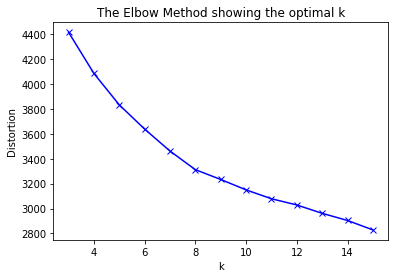

In [13]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

distortions = []
K = range(3,16)
for k in K:
    k_cluster = KMeans(n_clusters=k, max_iter=500, random_state=3425).fit(node_embeddings)
    k_cluster.fit(node_embeddings)
    distortions.append(k_cluster.inertia_)
    #distortions.append(sum(np.min(cdist(node_embeddings, k_cluster.cluster_centers_, 
    #                                    'euclidean'), axis=1)) / node_embeddings.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

The elbow method suggest the optimal number of clusters is somethere probably around 8.

In [14]:
# get clustering for 8 labels
kmeans_cluster = KMeans(n_clusters=10, 
                        init='k-means++', n_init=300, random_state=3425).fit(node_embeddings)
kmeans_labels = kmeans_cluster.labels_

In [15]:
#kmeans_labels_colors = []

In [16]:
# get clustering for 10 labels
#kmeans_cluster = KMeans(n_clusters=10,init='k-means++', n_init=100, random_state=3425).fit(node_embeddings)
#kmeans_labels = kmeans_cluster.labels_

Discuss exploring the clustering excersice

Talk about k-means, talk about hdbsacn

explanatio on why we want to use similarity matrix

explanation of why tsnet

In [17]:
import hdbscan
hdbs_model = hdbscan.HDBSCAN()
hdbs_model.fit(node_embeddings)
hbds_scan_labels = hdbs_model.labels_

In [18]:
# similarity
#hdbs_model_similarity = hdbscan.HDBSCAN(metric='precomputed')
#hdbs_model_similarity.fit(similarity_matrix)
#hbds_scan_labels_sim = hdbs_model_similarity.labels_

In [19]:
# data frame of nodes
nodes_labels = pd.DataFrame(zip(node_ids, kmeans_labels, hbds_scan_labels), 
                            columns = ['node_ids','kmeans','hdbscan'])
nodes_labels.groupby('kmeans').count()

,node_ids,hdbscan
kmeans,,
0,265,265
1,38,38
2,41,41
3,38,38
4,99,99
5,50,50
6,40,40
7,23,23
8,104,104


Explanation of the tsne algorithm


In [20]:
from sklearn.manifold import TSNE
trans = TSNE(n_components=2, early_exaggeration=20,
                  perplexity= 35, n_iter = 1000, n_iter_without_progress = 500,
                  learning_rate=500.0, random_state=42)
node_embeddings_2d = trans.fit_transform(node_embeddings)

In [21]:
data_tsne = pd.DataFrame(zip(node_ids, list(node_embeddings_2d[:,0]),list(node_embeddings_2d[:,1])),
                        columns = ['node_ids','x','y'])
data_tsne = pd.merge(data_tsne, nodes_labels, left_on='node_ids', right_on='node_ids',
                how = 'left')

<function matplotlib.pyplot.show(close=None, block=None)>

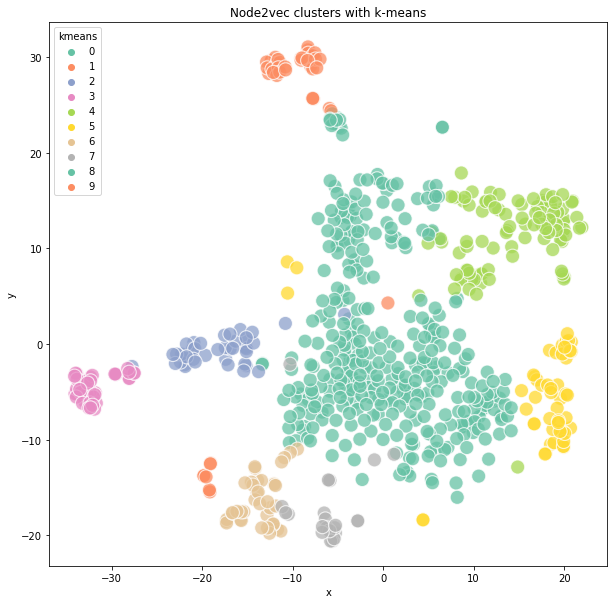

In [26]:
import seaborn as sns
plt.figure(figsize=(10, 10))
sns.scatterplot(data=data_tsne, x='x', y='y',hue='kmeans', palette="Set2",
               alpha=0.75, s=200).set_title('Node2vec clusters with k-means')
plt.savefig('images/kmeans_node2vec.svg')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

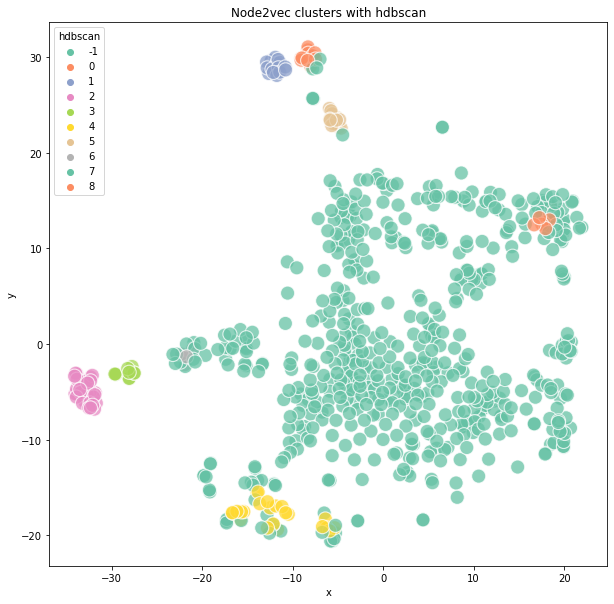

In [27]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=data_tsne, x='x', y='y',hue='hdbscan', palette="Set2",
               alpha=0.75, s=200).set_title('Node2vec clusters with hdbscan')
plt.savefig('images/hdbscan_node2vec.svg')
plt.show

We can see that TSNE in tandem with a simple kmean cluster does a decent job at creating separable clusters

Since we do not have ground truth labels of the nodes from the embeddings, lets get some summary statistics of the clusters and see how intuitive the results are based on these summary statistics. For this part of the analysis I will use the python implementation of igraph a popular network analysis library. I am interested in understanding if the embeddings are able to effectively capture structural similarities between nodes.

In [28]:
# transform the graph dataset into a proper format for igraph
nodes = graph_data['source'].tolist()+graph_data['target'].tolist()
nodes = pd.DataFrame(set(nodes), columns = ['nodes'])
g = ig.Graph.DataFrame(graph_data, directed=True, vertices = nodes)

In [29]:
# define a function to return the summary statistics of the nodes
# get indegree, out degree and betweeness centrality
def summary_stats_graph_nodes(graph):
    """
    graph: An ighaph object
    returns: a pandas dataframe
    """
    # get the nodes names
    nodes = list(graph.vs['name'])
    # get the indegree
    #indegree = ig.Graph.indegree(graph)
    indegree = ig.Graph.strength(graph, mode="in",  weights='weight')
    # get the outdegree
    #outdegree = ig.Graph.outdegree(graph)
    outdegree = ig.Graph.strength(graph, mode="out", weights='weight')
    # get hub centrality
    hub = ig.Graph.hub_score(graph, weights='weight')
    # get betweeness
    bet = ig.Graph.betweenness(graph, directed = True, weights='weight')
    # combine into one dataframe
    nodes_data = pd.DataFrame(zip(nodes,indegree,outdegree, hub, bet), columns = ['node', 'indegree', 
                                                                              'outdegree', 'hub_score',
                                                                              'betweenness'])
    nodes_data['net_out'] = nodes_data['indegree']-nodes_data['outdegree']
    nodes_data['flag'] = nodes_data['net_out'].apply(lambda x: 1 if x>0 else 0)
    nodes_data['color'] = nodes_data.apply(lambda x: 'green' if x['net_out']>0 and x['betweenness']>1000
                                                      else 'red', axis = 1)
    return nodes_data
    
nodes_data = summary_stats_graph_nodes(g)
nodes_data.head()

,node,indegree,outdegree,hub_score,betweenness,net_out,flag,color
0,Mount Vernon Ave & Four Mile Run Park,4868.0,4194.0,0.001144,1579.748550,674.0,1,green
1,11th & C St SE,7769.0,8606.0,0.011268,587.364638,-837.0,0,red
2,Westpark & Jones Branch Dr,1986.0,1927.0,0.000010,308.579958,59.0,1,red
3,Battery Ln & Trolley Trail,9487.0,9913.0,0.001375,2498.087309,-426.0,0,red
4,22nd & P ST NW,60089.0,55119.0,0.097392,713.961257,4970.0,1,red


In [38]:
# merge with the labels we define above
data = pd.merge(nodes_data, data_tsne[['node_ids','kmeans','hdbscan']], left_on='node', right_on='node_ids',
                how = 'left')
data['members']= data['node_ids'].groupby(data['kmeans']).transform('count')

In [39]:
data.groupby('kmeans').mean()

,indegree,outdegree,hub_score,betweenness,net_out,flag,hdbscan,members
kmeans,,,,,,,,
0,88568.377358,87592.754717,1.761547e-01,919.303743,975.622642,0.520755,4.675472,265.0
1,957.315789,971.289474,6.065945e-06,417.664104,-13.973684,0.500000,0.578947,38.0
2,11773.341463,14718.024390,1.234059e-02,1505.627881,-2944.682927,0.146341,-0.048780,41.0
3,1386.289474,1402.842105,7.163659e-06,414.563661,-16.552632,0.500000,2.236842,38.0
4,10539.575758,10199.545455,3.467454e-03,887.913936,340.030303,0.717172,-0.454545,99.0
5,2024.160000,2025.360000,1.131965e-03,643.578656,-1.200000,0.540000,-0.520000,50.0
6,4049.000000,4479.275000,1.308875e-03,1173.496796,-430.275000,0.275000,1.000000,40.0
7,1387.478261,1325.956522,4.390329e-04,785.885647,61.521739,0.695652,0.739130,23.0
8,9791.788462,11276.855769,5.693996e-03,1032.160356,-1485.067308,0.346154,-0.423077,104.0


In [43]:
data[data['node']=='Metro Center / 12th & G St NW']

,node,indegree,outdegree,hub_score,betweenness,net_out,flag,color,node_ids,kmeans,hdbscan,members
102,Metro Center / 12th & G St NW,211588.0,185686.0,0.395256,1614.739981,25902.0,1,green,Metro Center / 12th & G St NW,0,7,265


In [56]:
data[data['kmeans']==0].iloc[20:35]

,node,indegree,outdegree,hub_score,betweenness,net_out,flag,color,node_ids,kmeans,hdbscan,members
51,Lamont & Mt Pleasant NW,119321.0,154675.0,0.317409,1479.983440,-35354.0,0,red,Lamont & Mt Pleasant NW,0,7,265
52,Georgia Ave & Morton St NW,6398.0,8179.0,0.011049,949.516949,-1781.0,0,red,Georgia Ave & Morton St NW,0,-1,265
53,Iwo Jima Memorial/N Meade & 14th St N,47080.0,39414.0,0.063585,278.240393,7666.0,1,red,Iwo Jima Memorial/N Meade & 14th St N,0,-1,265
59,13th & D St NE,115790.0,120741.0,0.270343,496.957455,-4951.0,0,red,13th & D St NE,0,7,265
62,Connecticut Ave & R St NW,45135.0,42500.0,0.075790,769.886244,2635.0,1,red,Connecticut Ave & R St NW,0,7,265
66,14th & L St NW,54941.0,55795.0,0.108426,879.782424,-854.0,0,red,14th & L St NW,0,7,265
67,22nd & I St NW / Foggy Bottom,161640.0,161265.0,0.334744,1577.776007,375.0,1,green,22nd & I St NW / Foggy Bottom,0,7,265
70,18th & L St NW,9420.0,8144.0,0.013963,447.889589,1276.0,1,red,18th & L St NW,0,-1,265
71,Eastern Market Metro / Pennsylvania Ave & 7th ...,280631.0,286677.0,0.397045,1046.633343,-6046.0,0,red,Eastern Market Metro / Pennsylvania Ave & 7th ...,0,7,265
73,15th & M St NW,47899.0,48467.0,0.086261,1306.477438,-568.0,0,red,15th & M St NW,0,7,265


In [93]:
import plotly.express as px

stations = pd.read_csv('../data/capital_bikes/bike_locations.csv')
stations = pd.merge(stations, data, left_on='ADDRESS', right_on='node',
                how = 'inner')
stations['kmeans'] = stations['kmeans'].astype(str)
stations['size'] = 5 
fig = px.scatter_mapbox(stations, lat="LATITUDE", lon="LONGITUDE", hover_name="node", 
                        hover_data=['node'],
                        size = 'size',
                        size_max = 10,
                        zoom=10, 
                        width=700, height=600, 
                        color_discrete_sequence=px.colors.qualitative.Plotly,
                        color = 'kmeans',
                       )
fig.update_layout(mapbox_style="carto-positron")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [ ]:
# draw the embedding points, coloring them by the target label (paper subject)
import pylab as pl

alpha = 0.7
label_map = {l: i for i, l in enumerate(np.unique(node_ids))}

#replace with indegree
node_colours = kmeans_labels
#node_colours = hbds_scan_labels
plt.figure(figsize=(10, 10))
plt.axes().set(aspect="equal")
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
    label = kmeans_labels
)


#plt.legend()
#for i,type in enumerate(node_embeddings_2d):
#    x = node_embeddings_2d[i, 0]
#    y = node_embeddings_2d[i, 1]
#    plt.scatter(x, y, marker='.', c=node_colours[i])
    #plt.text(x+0.3, y+0.3, type, fontsize=9)
plt.title("{} visualization of node embeddings".format(transform.__name__))
plt.show()

In [ ]:
nodes = graph_data['source'].tolist()+graph_data['target'].tolist()
nodes = pd.DataFrame(set(nodes), columns = ['nodes'])
g = ig.Graph.DataFrame(graph_data, directed=True, vertices = nodes)

In [ ]:
# get indegree, out degree and betweeness centrality
def summary_stats_graph_nodes(graph):
    """
    graph: An ighaph object
    returns: a pandas dataframe
    """
    # get the nodes names
    nodes = list(graph.vs['name'])
    # get the indegree
    #indegree = ig.Graph.indegree(graph)
    indegree = ig.Graph.strength(graph, mode="in",  weights='weight')
    # get the outdegree
    #outdegree = ig.Graph.outdegree(graph)
    outdegree = ig.Graph.strength(graph, mode="out", weights='weight')
    # get hub centrality
    hub = ig.Graph.hub_score(graph, weights='weight')
    # get betweeness
    bet = ig.Graph.betweenness(graph, directed = True, weights='weight')
    # combine into one dataframe
    nodes_data = pd.DataFrame(zip(nodes,indegree,outdegree, hub, bet), columns = ['node', 'indegree', 
                                                                              'outdegree', 'hub_score',
                                                                              'betweenness'])
    nodes_data['net_out'] = nodes_data['indegree']-nodes_data['outdegree']
    nodes_data['flag'] = nodes_data['net_out'].apply(lambda x: 1 if x>0 else 0)
    nodes_data['color'] = nodes_data.apply(lambda x: 'green' if x['net_out']>0 and x['betweenness']>1000
                                                      else 'red', axis = 1)
    return nodes_data
    
nodes_data = summary_stats_graph_nodes(g)
nodes_data.head()

In [ ]:
data = pd.merge(nodes_data, nodes_labels, left_on='node', right_on='node_ids',
                how = 'left')
data[data['node']=='Convention Center / 7th & M St NW']

In [ ]:
data[data['kmeans']==9]

In [ ]:
#g.vs['color'] = g.get_many(i.membership)
g.vs["color"] = nodes_data['color'].tolist()

In [ ]:
# Define colors used for outdegree visualization
#colours = ['red', 'green']
visual_style = {}
# Set bbox and margin
visual_style["bbox"] = (500,500)
visual_style["margin"] = 15

# Set vertex colours
#visual_style["vertex_color"] = 'grey'

# Set vertex size
visual_style["vertex_size"] = 10

# Set vertex lable size
visual_style["vertex_label_size"] = 8

# Don't curve the edges
visual_style["edge_curved"] = False
visual_style['edge_arrow_size'] = 0.01
visual_style['edge_width'] = 0.1
# Set the layout
my_layout = g.layout_grid_fruchterman_reingold()
visual_style["layout"] = my_layout

In [ ]:
# Plot the graph
#ig.plot(g, 'out_fig_name.svg', **visual_style)

In [ ]:
rw = BiasedRandomWalk(graph_bikes, p = 1, q = 0.5, n = 10, length = 80, 
                      seed=42, weighted = True)

In [ ]:
walks = rw.run(nodes=list(graph_bikes.nodes())
               # root nodes
              )
print("Number of random walks: {}".format(len(walks)))

In [ ]:
str_walks = [[str(n) for n in walk] for walk in walks]

In [ ]:
str_walks

In [ ]:
len(str_walks[20])

In [ ]:
model = Word2Vec(str_walks, size=80, window=10, min_count=1, sg=1, workers=4, iter=20)
#model.wv.most_similar('Lincoln Memorial')

In [ ]:
model.wv.most_similar('Fort Totten Metro')

In [ ]:
# add tsne visualization and network visualization
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = (
    model.wv.vectors
)  # numpy.ndarray of size number of nodes times embeddings dimensionality

In [ ]:
transform = TSNE  # PCA

trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(node_embeddings)

In [ ]:
# draw the embedding points, coloring them by the target label (paper subject)
import pylab as pl

alpha = 0.7
label_map = {l: i for i, l in enumerate(np.unique(node_ids))}

#replace with indegree
#node_colours = [label_map[target] for target in node_targets]
plt.figure(figsize=(10, 10))
plt.axes().set(aspect="equal")
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c='blue',
    cmap="jet",
    alpha=alpha,
)

for i,type in enumerate(label_map):
    x = node_embeddings_2d[i, 0]
    y = node_embeddings_2d[i, 1]
    plt.scatter(x, y, marker='x', color='red')
    plt.text(x+0.3, y+0.3, type, fontsize=9)
plt.title("{} visualization of node embeddings".format(transform.__name__))
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.spatial.distance import cdist, pdist
from matplotlib import cm

k=[]
within_var=[]
total_sumsq=[]
between_var=[]
total_varexplained=[]
just_for_funbss=[]
vrc=[]
s_scores=[]

for i in range(5,20):
    k.append(i)
    prueba1a=KMeans(n_clusters=i,init='k-means++', n_init=100, random_state=3425).fit(node_embeddings)
    k_euclid=cdist(node_embeddings,prueba1a.cluster_centers_,'euclidean')
    dist=np.min(k_euclid, axis=1)
    wvar=sum(dist**2)
    tssq=sum(pdist(node_embeddings)**2)/node_embeddings.shape[0]
    bss=tssq-wvar
    total_varexplained.append(bss/tssq)
    between_var.append(bss)
    total_sumsq.append(tssq)
    within_var.append(wvar)
    squared_centroids=(np.array(prueba1a.cluster_centers_)**2)
    count=np.bincount(prueba1a.labels_)
    just_for_funbss.append(sum(sum(squared_centroids*count[:,None])))
    CH= (bss/wvar)*((300-i)/(i-1))
    vrc.append(CH)
    s_scores.append(silhouette_score(node_embeddings,prueba1a.labels_, 
                     metric='euclidean'))
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(k, np.asarray(between_var)/np.asarray(total_sumsq)*100,)
plt.grid(True)
plt.xlabel('Percentage of variance explained (%)')
plt.ylabel('Number of clusters')
plt.title('Elbow for KMeans clustering')
plt.show()

In [ ]:
def tsne_data(arrays, ids, nodes_labels, dimensions = 2):
    trans = TSNE(n_components=dimensions, early_exaggeration=20,
                  perplexity= 35, n_iter = 1000, n_iter_without_progress = 500,
                  learning_rate=500.0, random_state=42)
    trans = trans.fit_transform(arrays)
    data_tsne = pd.DataFrame(zip(ids, list(trans[:,0]),list(trans[:,1])),
                        columns = ['node_ids','x','y'])
    data_tsne = pd.merge(data_tsne, nodes_labels, left_on='node_ids', right_on='node_ids',
                how = 'left')
    return data_tsne